(tensor-network-2d)=

# 2D Algorithms

As with 1D tensor networks (TNs), 2D TNs in `quimb` are a combination of
'mixin' subclasses of {class}`~quimb.tensor.tensor_core.TensorNetwork` each
with some extra details about how the  tensors are labelled and indices named.
Having this extra information about the 2D structure then allows special
methods for e.g.  boundary contraction.

Here's a quick reference of some key objects:

- {class}`~quimb.tensor.tensor_2d.TensorNetwork2D`
- {class}`~quimb.tensor.tensor_2d.PEPS`
- {class}`~quimb.tensor.tensor_2d.PEPO`
- {class}`~quimb.tensor.tensor_2d_tebd.LocalHam2D`

And key algorithms:

- {class}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary`
- {class}`~quimb.tensor.tensor_2d.TensorNetwork2DVector.gate`
- {class}`~quimb.tensor.tensor_2d.TensorNetwork2DVector.compute_local_expectation`
- {class}`~quimb.tensor.tensor_2d_tebd.SimpleUpdate`
- {class}`~quimb.tensor.tensor_2d_tebd.FullUpdate`

## Structure of a 2D Tensor Network

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

As an example we can take a look at a randomly generated PEPS, which also inherits
methods from these mixin subclasses: {class}`~quimb.tensor.tensor_2d.TensorNetwork2DVector`
and {class}`~quimb.tensor.tensor_2d.TensorNetwork2DFlat`,
since it has a) a single physical index per site and
b) a single tensor per site, respectively.

In [2]:
peps = qtn.PEPS.rand(Lx=5, Ly=5, bond_dim=3, seed=666)
peps

PEPS(tensors=25, indices=65, Lx=5, Ly=5, max_bond=3)

In [3]:
peps.show()

    3    3    3    3   
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱┃3  ╱┃3  ╱┃3  ╱┃3  ╱┃3  
 ┃  3 ┃  3 ┃  3 ┃  3 ┃ 
 ●━━━━●━━━━●━━━━●━━━━●
╱    ╱    ╱    ╱    ╱    


You can see all the special properties the `PEPS` class carries with:

In [4]:
peps._EXTRA_PROPS

('_site_tag_id', '_x_tag_id', '_y_tag_id', '_Lx', '_Ly', '_site_ind_id')

This enable various convenient functions:

In [5]:
# index specifying an physical site
peps.site_ind(3, 4)

'k3,4'

In [6]:
# tag specifying a coordinate
peps.site_tag(3, 4)

'I3,4'

In [7]:
# access by coordinate rather than full tag
peps[3, 4]

Tensor(shape=(3, 3, 3, 2), inds=('_aea46cAAAAj', '_aea46cAAAAa', '_aea46cAAAAi', 'k3,4'), tags=oset(['I3,4', 'X3', 'Y4']))

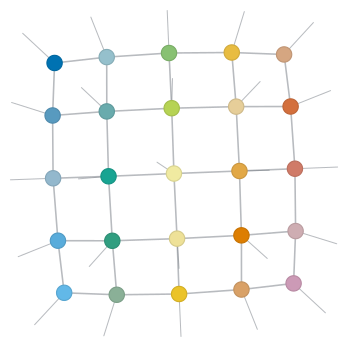

In [8]:
peps.draw(color=peps.site_tags)

## Combining 2D Tensor Networks

When you combine two 2D tensor networks with the `&` or `|` operators the
new combined TN will be `~quimb.tensor.tensor_2d.TensorNetwork2D` if they are
compatible (i.e. all extra properties match). That means that if you combine two
PEPS for example, the new object still has a boundary contraction method.

In [9]:
norm = peps.H & peps
norm

TensorNetwork2D(tensors=50, indices=105, Lx=5, Ly=5, max_bond=3)

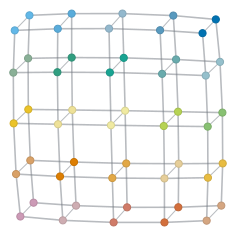

In [10]:
norm.draw(color=norm.site_tags, figsize=(4, 4))

## Contracting 2D Tensor Networks

Note that unlike 1D tensor networks, 2D tensor networks cannot be efficiently
contracted exactly, and so care should taken when calling `.contract`
directly. Our PEPS here is still small enough however for our memory:

In [11]:
norm.contract(all, optimize='auto-hq')

0.5077521135992215

The `contract` function then treats it as any other tensor network.

More generally, one would want to use **boundary contraction** to approximately
contract any 2D tensor networks, using one of the following methods:

- {meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary`,
- {meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary_from_bottom`,
- {meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary_from_left`,
- {meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary_from_top`,
- {meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary_from_right`,

Here, one *compresses* between tensors as we
contract to limit bonds from growing beyond a maximum size:

In [12]:
%%time
norm.contract_boundary(max_bond=32)

CPU times: user 1.62 s, sys: 34.8 ms, total: 1.65 s
Wall time: 234 ms


0.506999178700516

We can see here than the answer is slightly off, even with a large bond
dimension of `64` (random PEPS are harder than 'physical' PEPS to
contract usually).

:::{warning}
The default options for
{meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary` are those
of {func}`~quimb.tensor.tensor_core.tensor_split`, meaning
`max_bond=None` (no dimension limit) and `cutoff=1e-10` (only remove
very small singular values). **These won't be nearly aggressive enough to
contract most 2D TNs efficiently - you should set these!**
:::

By default `contract_boundary` also flattens the TN as it goes. 
If you want to do a multilayer boundary contraction you need to tag
the different layers and specify them:

In [13]:
peps.add_tag('KET')
pepsH = peps.conj().retag({'KET': 'BRA'})
norm = pepsH & peps

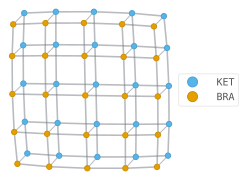

In [14]:
norm.draw(color=['KET', 'BRA'], figsize=(3, 3))

Now we can specify `layer_tags=['KET', 'BRA']` to any of the boundary 
contraction methods. Here we perform an inplace boundary contraction around
the sites `(2, 2)` and `(2, 3)`.

In [15]:
norm.contract_boundary_(max_bond=64, layer_tags=['KET', 'BRA'], around=((2, 2), (2, 3)))

TensorNetwork2D(tensors=15, indices=29, Lx=5, Ly=5, max_bond=64)

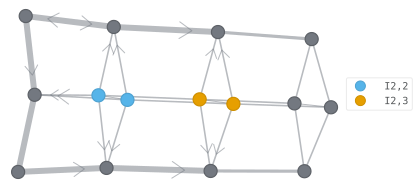

In [16]:
norm.draw(color=[norm.site_tag(2, 2), norm.site_tag(2, 3)], show_tags=False)

Note the tensors on the right haven't been flattened as they on the boundary already.

## Computing Quantites

Contracting the boundary of two sandwiched PEPS around regions (which
can be thought of as the approximate partial trace) is also the main routine
required inside
{meth}`~quimb.tensor.tensor_2d.TensorNetwork2DVector.compute_local_expectation`.

In [17]:
# two spin operator
H2 = qu.ham_heis(2)

# coordinates to act with operator on
coo_a = (2, 2)
coo_b = (2, 3)

# compute expectation
peps.compute_local_expectation(
    {(coo_a, coo_b): H2}, 
    max_bond=64,
    normalized=True, 
)

0.0004870786802363588

:::{note}
We have specified the boundary contraction option `max_bond`, and also
the `normalized=True` option, which computes

$$
\langle\hat{O}\rangle =
\frac{
\langle \psi | \hat{O} | \psi \rangle
}{
\langle \psi | \psi \rangle
}
$$

which reuses the environments to 'locally' normalize the state rather than doing
it in a separate step. By default, two layer boundary contraction is also used
since this is more efficient (but this can be turned off).
:::

Often we want to compute many of these at once, e.g. when computing the energy
of a Hamiltonian, without repeating many boundary boundary contractions:

In [18]:
# compute the heisenberg interaction for every bond in the PEPS lattice
terms = {
    (coo_a, coo_b): H2
    for coo_a, coo_b in peps.gen_bond_coos()
}

peps.compute_local_expectation(
    terms, 
    max_bond=64,
    normalized=True, 
)

0.26752530504966576

This automatically calculates which 'plaquette' environments are required then
computes them in at most one boundary contraction inwards from each direction.
There are various options for manually controlling this, with the main driver
function being
{meth}`~quimb.tensor.tensor_2d.TensorNetwork2D.compute_plaquette_environments`.

## Specifying 2D Hamiltonians

Such a dictionary of terms can also be generated by instantiating a
{class}`~quimb.tensor.tensor_2d_tebd.LocalHam2D`, which additionally

- sums two site and one site terms so there is at most one term per pair
- can generate commuting term groupings for arbitrary range interactions
- can plot the Hamiltonian for interactive usage with
  {meth}`~quimb.tensor.tensor_2d_tebd.LocalHam2D.graph`

This is the object that is required for both the
{class}`~quimb.tensor.tensor_2d_tebd.SimpleUpdate` and
{class}`~quimb.tensor.tensor_2d_tebd.FullUpdate`
algorithms.

Here we'll first make the translationally invariant Heisenberg Hamiltonian:

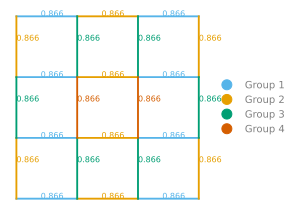

(<Figure size 400x400 with 1 Axes>, <Axes: >)

In [19]:
Lx = 4
Ly = 4

ham = qtn.LocalHam2D(Lx, Ly, H2=H2)
ham.draw()

The ``H2`` kwarg describes two site interactions. If an operator is given directly (as here)
it is used as a default term for all nearest neighbor interactions, as can be seen in the
visualization above.
We can also mix default single and two body terms and those for specific sites:

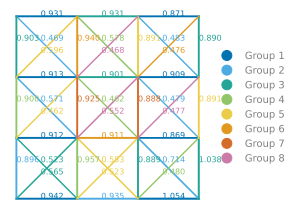

(<Figure size 400x400 with 1 Axes>, <Axes: >)

In [20]:
# the default two body term
H2 = {None: qu.ham_heis(2)}

# single site terms
H1 = {}

for i in range(Lx):
    for j in range(Ly):
        
        # add next nearest neighbor interactions
        if (i + 1 < Lx) and (j - 1 >= 0):
            H2[(i, j), (i + 1, j - 1)] = 0.5 * qu.ham_heis(2)
        if (i + 1 < Lx) and (j + 1 < Ly):
            H2[(i, j), (i + 1, j + 1)] = 0.5 * qu.ham_heis(2)
        
        # add a random field
        H1[i, j] = qu.randn() * qu.spin_operator('Z')
        
ham_nn_r = qtn.LocalHam2D(Lx, Ly, H2=H2, H1=H1)
ham_nn_r.draw()

The coloring shows a potential grouping of commuting two site terms.

This object has the `.terms` attribute which can be supplied to
{meth}`~quimb.tensor.tensor_2d.TensorNetwork2DVector.compute_local_expectation`

In [21]:
peps.compute_local_expectation(ham_nn_r.terms, max_bond=32)

0.1123889724020653

In the next few sections we'll try and find the groundstate of the 
4x4 Heisenberg lattice:

In [22]:
Lx = 4
Ly = 4

ham = qtn.LocalHam2D(Lx, Ly, H2=qu.ham_heis(2))

This is small enough to easily compute the exact groundstate energy:

In [23]:
energy_exact = qu.groundenergy(qu.ham_heis_2D(Lx, Ly, sparse=True)) / (Lx * Ly)
energy_exact

-0.5743254415745597

## Simple Update

We can use our {class}`~quimb.tensor.tensor_2d_tebd.LocalHam2D` object as the
input to the 'Simple Update' (SU) algorithm, for performing imaginary time evolution.
Here we'll find the \$D=4\$ SU groundstate of the Heisenberg Hamiltonian:

In [24]:
D = 4
psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=D, seed=666)

In [25]:
su = qtn.SimpleUpdate(
    psi0, 
    ham,
    chi=32,  # boundary contraction bond dim for computing energy
    compute_energy_every=10,
    compute_energy_per_site=True,
    keep_best=True,
)

In [26]:
for tau in [0.3, 0.1, 0.03, 0.01]:
    su.evolve(100, tau=tau)

n=400, tau=0.0100, energy~-0.562843: 100%|##########| 100/100 [00:07<00:00, 13.68it/s]


The current state can be retrieved from `su.state`, or, if you have specified the
`keep_best` option, the lowest energy state seen can be found in `su.best['state']`.

In [27]:
su.best

{'energy': -0.5633772517149431,
 'state': <PEPS(tensors=16, indices=40, Lx=4, Ly=4, max_bond=4)>,
 'it': 110}

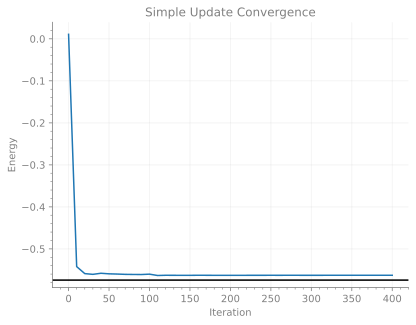

In [28]:
from matplotlib import pyplot as plt

with plt.style.context(qu.NEUTRAL_STYLE):
    plt.plot(su.its, su.energies)
    plt.axhline(energy_exact, color='black')
    plt.title('Simple Update Convergence')
    plt.ylabel('Energy')
    plt.xlabel('Iteration');

## Full Update

Simple Update assumes a particular environment when truncating after each local application
of the imaginary time evolution operators - a product of diagonal operators - while very cheap
this can be innacurate. Full Update instead fits the new PEPS after each local evolution using
the local tensors as well as a boundary contracted environment.

In [29]:
# use the best SU state as the starting point for FU
psi0 = su.best['state'].copy()

The way these algorithms are written using 
[autoray](https://github.com/jcmgray/autoray) means that we can convert
the backend arrays of our PEPS and Hamiltonian to e.g. GPU arrays and
everything should still run smoothly.

In the following (optional) cell, we convert to the arrays to single
precision ``cupy`` arrays, since FU is a good candidate for GPU acceleration.

In [30]:
def to_backend(x):
    import cupy as cp
    return cp.asarray(x).astype('float32')

psi0.apply_to_arrays(to_backend)
ham.apply_to_arrays(to_backend)

In [31]:
fu = qtn.FullUpdate(
    psi0=psi0,
    ham=ham,
    # chi again is the boundary contraction max_bond
    # now used for the envs as well as any energy calc
    chi=32,
    # we thus can cheaply compute the energy at every step
    compute_energy_every=1,
    compute_energy_per_site=True,
    keep_best=True,
)

In [32]:
fu.evolve(50, tau=0.1)

n=50, tau=0.1000, energy~-0.571752: 100%|##########| 50/50 [01:10<00:00,  1.42s/it]


In [33]:
fu.evolve(50, tau=0.03)

n=100, tau=0.0300, energy~-0.573182: 100%|##########| 50/50 [00:57<00:00,  1.14s/it]


In [34]:
fu.evolve(50, tau=0.01)

n=150, tau=0.0100, energy~-0.573563: 100%|##########| 50/50 [00:55<00:00,  1.11s/it]


We can see we have improved on the SU groundstate significantly.

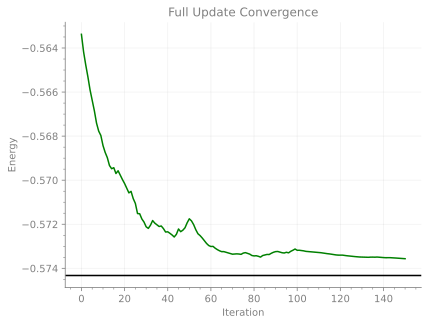

In [35]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plt.plot(fu.its, fu.energies, color='green')
    plt.axhline(energy_exact, color='black')
    plt.title('Full Update Convergence')
    plt.ylabel('Energy')
    plt.xlabel('Iteration');

Full Update has many options relating to the fitting of the imaginary 
time evolution gates, controlling tradeoff between efficiency 
and accuracy, you can view them like so:

In [36]:
fu.fit_opts

{'tol': 1e-10,
 'steps': 20,
 'init_simple_guess': True,
 'condition_tensors': True,
 'condition_maintain_norms': True,
 'als_dense': True,
 'als_solver': 'solve',
 'als_enforce_pos': False,
 'als_enforce_pos_smudge': 1e-06,
 'autodiff_backend': 'autograd',
 'autodiff_optimizer': 'L-BFGS-B'}

For example, the following might be helpful to converge to very high accuracy:

In [37]:
fu.fit_opts['als_enforce_pos'] = True

## Global Autodiff Optmization

Because of the aforementioned array agnoticism that `quimb` tries to adopt, we can
also perform nearly all 2D calculations using arrays/tensors from an autodiff library,
to compute gradients and thus efficiently optimize entire tensor networks at once.
The {class}`~quimb.tensor.optimize.TNOptimizer` object handles injecting autodiff
arrays from one of several libraries currently):

- [autograd](https://github.com/HIPS/autograd)
- [jax](https://github.com/google/jax)
- [tensorflow](https://www.tensorflow.org/)
- [pytorch](https://pytorch.org/)

then using the automatically generated gradients from any expression to feed to
scipy's optimize function. Optimizing for a 2D PEPS energy is a great example
of this.
All we need to do is setup a function (a 'loss') that returns a real scalar
to minimize.

In [2]:
Lx = Ly = 4
psi0 = qtn.PEPS.rand(Lx, Ly, bond_dim=4)
ham = qtn.LocalHam2D(Lx, Ly, H2=qu.ham_heis(2))

def loss(psi, terms):
    # the following functions simply scale the various tensors
    #     for the sake of numerical stability
    psi.balance_bonds_()
    psi.equalize_norms_(1.0)
    
    # then we just compute the energy of all the terms
    return psi.compute_local_expectation(
        terms,
        max_bond=32,
        cutoff=0.0,
        normalized=True
    ) / (Lx * Ly)

(Setting `cutoff=0.0` is required here so that the autodiff doesn't encounter
bahavior/shapes dependent on actual array values.)
Next we create a {class}`~quimb.tensor.optimize.TNOptimizer` object:

In [3]:
tnopt = qtn.TNOptimizer(
    # initial TN to optimize
    psi0,                                 
    # the function to minimize
    loss_fn=loss,                         
    # constant TNs, tensors, arrays
    loss_constants={'terms': ham.terms},  
    # the library that computes the gradient
    autodiff_backend='jax',               
    # the scipy optimizer that makes use of the gradient
    optimizer='L-BFGS-B',                 
)

The first step might be slow (e.g. with ``'jax'``) as it compiles the whole 
energy and gradient computation:

In [4]:
tnopt.optimize(1)

-0.103467911482 [best: -0.103467911482] : : 2it [00:48, 24.42s/it]                     


<PEPS(tensors=16, indices=40, Lx=4, Ly=4, max_bond=4)>

Subsequent optimization steps should be very quick, especially on a GPU:

In [5]:
psi_opt = tnopt.optimize(999)

-0.574177205563 [best: -0.574177205563] :  20%|█▉        | 198/999 [00:32<02:12,  6.06it/s]


We can then check the convergence:

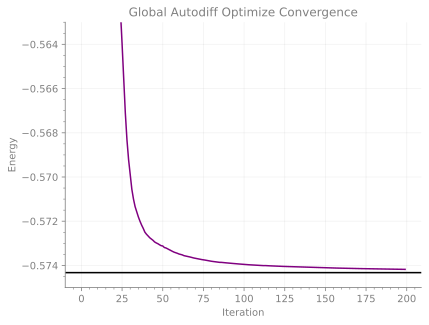

In [10]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plt.plot(tnopt.losses, color='purple')
    plt.axhline(energy_exact, color='black')
    plt.title('Global Autodiff Optimize Convergence')
    plt.ylabel('Energy')
    plt.ylim(-0.575, -0.563)
    plt.xlabel('Iteration');

We can see that we have rapidly achieved a lower energy than Full Update.

:::{warning}
Global autodiff optimization can be **too powerful** for TN computations
that involve approximate contraction in the sense that the optimization
starts to exploit the small errors in the approximation to yield wildly
low but innacurate energies. That is part of the reason for including
the conditioning steps:

```{code} python3
psi.balance_bonds_()
psi.equalize_norms_(1.0)
```

in our loss function as well as 'locally normalizing' the energies.
It is also thus worth checking with a large bond dimension what our final
energy is more accurately. We can see below it matches well here.
:::

In [11]:
psi_opt.compute_local_expectation(
    ham.terms, normalized=True, max_bond=100
) / (Lx * Ly)

-0.5741719873138484